## Quick and dirty trust simulation

In [1]:
# import mate
import avstack

from avstack.datastructs import DataContainer
from avstack.geometry import GlobalOrigin2D, Position, Circle
from avstack.modules.perception.detections import CentroidDetection
from avstack.modules.tracking.tracker2d import BasicXyTracker

import numpy as np
import pandas as pd
from scipy.stats import beta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
from labellines import labelLine, labelLines

import os

TINY_SIZE = 10
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

marker_large = 10
marker_medium = 8
marker_small = 5
linewidth = 3



matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

No torch found.
MIDAS module not found.
Cannot use sklearn methods


/home/spencer/.cache/pypoetry/virtualenvs/mate-anjulgyC-py3.10/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def init_agents(radius):
    # agent info
    agents = [
        np.array([0, 0]),
        np.array([1, 0]),
        np.array([1/2, np.sqrt(3/4)])
    ]
    fovs = [Circle(radius=radius, center=agent) for agent in agents]
    platforms = [GlobalOrigin2D for _ in agents]

    return agents, fovs, platforms


def init_objects(fovs, n_objects=5, min_dist=0.1, force_object_case=False):
    if force_object_case: 
        objects = [
            np.array([0, 0.5]),   # in agents 0, 1
            np.array([0.2, 0.5]), # in agents 0, 1
            np.array([-0.5, 0]),  # in agent  1
            np.array([0.5, 0.5]), # in agents 0, 1, 2
            np.array([1, 0.6]),   # in agents 1, 2
        ]
    else:
        objects = []
        for _ in range(n_objects):
            while True:
                obj = np.random.uniform(low=-0.5, high=1.5, size=(2,))
                if any(fov.check_point(obj) for fov in fovs):
                    if not any(np.linalg.norm(obj - o2) < min_dist for o2 in objects):
                        break
            objects.append(obj)
    return objects


def init_adversary(fovs, objects, n_fp, n_fn, min_dist=0.25, force_adv_case=False):
    # false positives
    if force_adv_case: 
        fps = [
            (0, np.array([0.5, 0.3])),  # (agent 0, location)
            (0, np.array([0.45, -0.5])),
            (1, np.array([0.8, 0.4])),
        ]
    else:
        fps = []
        for _ in range(n_fp):
            while True:
                idx_agent = np.random.randint(low=0, high=len(fovs))
                obj = np.random.uniform(low=-0.5, high=1.5, size=(2,))
                if fovs[idx_agent].check_point(obj):
                    if not any(np.linalg.norm(obj - o2[1]) < min_dist for o2 in fps):
                        if not any(np.linalg.norm(obj - o2) < min_dist for o2 in objects):
                            fps.append((idx_agent, obj))
                            break

    # false negatives
    if force_adv_case:
        fns = [
            (0, 1),  # (agent 0, object 1)
        ]
    else:
        fns = []
        for _ in range(n_fn):
            while True:
                idx_agent = np.random.randint(low=0, high=len(fovs))
                idx_object = np.random.randint(low=0, high=len(objects)) 
                if (idx_agent, idx_object) not in fns:
                    if fovs[idx_agent].check_point(objects[idx_object]):
                        fns.append((idx_agent, idx_object))
                        break
    
    return fps, fns    


def init_tracker(agents):
    multi_tracker = avstack.modules.tracking.multisensor.MeasurementBasedMultiTracker(
        tracker=BasicXyTracker(threshold_confirmed=4, assign_radius=0.1),
        platform=GlobalOrigin2D,
    )
    agent_trackers = {
        i: BasicXyTracker(threshold_confirmed=4, assign_radius=0.1)
        for i in range(len(agents))
    }
    return multi_tracker, agent_trackers


def detect(agents, radius, objects, fps, fns, frame, timestamp):
    detections = {}
    labels = {}
    for i, agent in enumerate(agents):
        dets = []
        for j, obj in enumerate(objects):
            if (i,j) in fns:
                continue
            else:
                if np.linalg.norm(agent - obj) <= radius:
                    dets.append(CentroidDetection(i, obj, reference=GlobalOrigin2D))
        for j, fp in enumerate(fps):
            if fp[0] == i:
                dets.append(CentroidDetection(i, fp[1], reference=GlobalOrigin2D))
        detections[i] = DataContainer(frame=frame, timestamp=timestamp, data=dets, source_identifier=i)
    return detections


def plot_agents_objects(agents, fovs, objects, fps, fns, fig_dir="figures"):
    # -- plot full picture
    fig, ax = plt.subplots()
    agent_colors = "rgb"
    # plot agents
    for agent, fov, color in zip(agents, fovs, agent_colors):
        ax.plot(*agent, '*', markersize=marker_medium, color=color)
        circle = plt.Circle(agent, fov.radius, color=color, alpha=0.4)
        ax.add_patch(circle)
    
    # plot objects
    for i, object in enumerate(objects):
        ax.plot(*object, 'o', markersize=marker_medium, color="black", label="Truth" if i==0 else "")
    
    # plot false positives
    for i, fp in enumerate(fps):
        ax.plot(*fp[1], 'x', markersize=marker_medium, color=agent_colors[fp[0]], label="FP" if i == 0 else "")
    
    # plot false negatives
    for i, fn in enumerate(fns):
        ax.plot(*objects[fn[1]], '+', markersize=marker_large, color=agent_colors[fn[0]], label="FN" if i == 0 else "")
    
    # set limits
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_truth.pdf"))
    plt.show()
    

def plot_detections(agents, radius, dets, objects=None, fig_dir="figures"):
    # -- plot detections only
    fig, ax = plt.subplots()
    agent_colors = "rgb"
    # plot agents
    for agent, color in zip(agents, agent_colors):
        ax.plot(*agent, '*', markersize=marker_large, color=color)
        circle = plt.Circle(agent, radius, color=color, alpha=0.4)
        ax.add_patch(circle)
    
    # plot objects
    if objects:
        for i, object in enumerate(objects):
            ax.plot(*object, 'o', markersize=marker_medium, color="black", label="Truth" if i==0 else "")
    
    # plot detections
    det_markers = "123"
    for i_agent, ds in dets.items():
        for j, det in enumerate(ds):
            ax.plot(*det.x, det_markers[i_agent], markersize=marker_large+4, alpha=1, color=agent_colors[i_agent],
                    label="Detection" if j==0 else "")
    
    # set limits
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_detections.pdf"))
    plt.show()


def plot_clusters(agents, radius, clusters, objects=None, fig_dir="figures"):
    # plot clusters
    fig, ax = plt.subplots()
    agent_colors = "rgb"
    # plot agents
    for agent, color in zip(agents, agent_colors):
        ax.plot(*agent, '*', markersize=marker_large, color=color)
        circle = plt.Circle(agent, radius, color=color, alpha=0.4)
        ax.add_patch(circle)
    
    # plot objects
    if objects:
        for i, object in enumerate(objects):
            ax.plot(*object, 'o', markersize=marker_large, color="black", label="Truth" if i==0 else "")
    
    # plot clusters
    for j, clust in enumerate(clusters):
        pos = clust.centroid().x
        ax.plot(*pos, "x", markersize=marker_large, color="orange", label="Cluster" if j==0 else "", alpha=0.8)
        ax.text(pos[0]+0.02, pos[1]+0.02, j)
    
    # set limits
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_clusters.pdf"))
    plt.show()


def plot_tracks(agents, radius, tracks, objects=None, fig_dir="figures"):
    # plot tracks
    fig, ax = plt.subplots()
    agent_colors = "rgb"
    # plot agents
    for agent, color in zip(agents, agent_colors):
        ax.plot(*agent, '*', markersize=marker_large, color=color)
        circle = plt.Circle(agent, radius, color=color, alpha=0.4)
        ax.add_patch(circle)
    
    # plot objects
    if objects:
        for i, object in enumerate(objects):
            ax.plot(*object, 'o', markersize=marker_large, color="black", label="Truth" if i==0 else "")
    
    # plot tracks
    for j, track in enumerate(tracks):
        pos = track.position.x
        ax.plot(*pos, "x", markersize=marker_large, color="orange", label="Track" if j==0 else "", alpha=0.8)
        ax.text(pos[0]+0.02, pos[1]+0.02, j)
    
    # set limits
    ax.set_xlim([-1, 2])
    ax.set_ylim([-1, 2])
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_tracks.pdf"))
    plt.show()

In [3]:
def plot_trust(trust_estimator, objects=None, use_labellines=False, fig_dir="figures"):
    # assign last tracks to truths, if possible
    if objects is not None:
        A = avstack.modules.assignment.build_A_from_distance(trust_estimator.tracks, objects)
        assigns = avstack.modules.assignment.gnn_single_frame_assign(A, cost_threshold=0.1)
    else:
        assigns = None

    # plot all track trust distributions
    fig, ax = plt.subplots(figsize=(5,4))
    x = np.linspace(0, 1.0, 10000)
    IDs = np.array([trk.ID for trk in trust_estimator.tracks])
    for ID in sorted(trust_estimator.track_trust):
        idx_track = np.argwhere(ID == IDs)[0][0]
        if assigns is not None:
            label = f"{idx_track}: True Object" if assigns.has_assign(row=idx_track) \
                else f"{idx_track}: False Pos."
        else:
            label=f"Track {ID}"
        linestyle = "-" if "True" in label else "--"
        y = beta.pdf(x, trust_estimator.track_trust[ID].alpha, trust_estimator.track_trust[ID].beta)
        ax.plot(x, y, linewidth=linewidth, linestyle=linestyle, label=label)

    if use_labellines:
        lines = ax.get_lines()
        xs = np.linspace(0.3, 0.7, len(lines))
        for i, line in enumerate(lines):
            labelLine(
                line,
                xs[i],
                label=r"{}".format(line.get_label().split(":")[0]),
                ha="left",
                va="bottom",
                align=False,
                backgroundcolor="none",
            )

    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 10])
    ax.legend(loc="upper right")
    ax.set_xlabel("Track Trust Score")
    ax.set_ylabel("PDF")
    ax.set_yticklabels([])
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_track_trusts.pdf"))
    plt.show()

    # plot all agent trust distributions
    cs = "rgb"
    fig, ax = plt.subplots(figsize=(5,4))
    x = np.linspace(0, 1.0, 10000)
    for ID, color in zip(trust_estimator.agent_trust, cs):
        # y = np.diff(trust_estimator.agent_trust[ID])
        # x = np.linspace(0, 1.0, len(y))
        # dx = x[1] - x[0]
        # y /= sum(y)*dx
        y = beta.pdf(x, trust_estimator.agent_trust[ID].alpha, trust_estimator.agent_trust[ID].beta)
        ax.plot(x, y, color=color, linewidth=linewidth, linestyle=linestyle, label=f"Agent {ID}")

    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 10])
    ax.legend(loc="upper right")
    ax.set_xlabel("Agent Trust Score")
    ax.set_ylabel("PDF")
    ax.set_yticklabels([])
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_agent_trusts.pdf"))
    plt.show()



def classify(trust):
    if trust < 0.4:
        return -1
    elif trust > 0.7:
        return 1
    else:
        return 0


def run_metrics(trust_estimator, fovs, objects):
    # assign last tracks to truths
    tracks = trust_estimator.tracks
    A = avstack.modules.assignment.build_A_from_distance(tracks, objects)
    assigns = avstack.modules.assignment.gnn_single_frame_assign(A, cost_threshold=0.1)
    IDs_assign = [tracks[j_track].ID for j_track in assigns._row_to_col]

    # make track trust predictions
    means = {ID: ps.alpha/(ps.alpha+ps.beta) for ID, ps in trust_estimator.track_trust.items()}
    predictions = {ID: classify(mean) for ID, mean in means.items()}

    # get number of observers per track/lone-object
    n_obs_unassign = {i: sum([fov.check_point(objects[idx][:2]) for fov in fovs]) for i, idx in enumerate(assigns.unassigned_cols)}
    n_obs_trks = {obj.ID: sum([fov.check_point(obj.x[:2]) for fov in fovs]) for obj in tracks}

    # get metrics based on num of observers
    cases_all = {}
    for i_obs in range(1, len(fovs)+1, 1):
        cases = {}
        # case 0: false negative of true object (no track)
        cases[0] = sum([True for i in n_obs_unassign if n_obs_unassign[i] == i_obs])
    
        # case 1: true track predicts as valid
        cases[1] = sum([pred == 1 for ID, pred in predictions.items() if (ID in IDs_assign) and (n_obs_trks[ID] == i_obs)])
    
        # case 2: true track predicts as unknown
        cases[2] = sum([pred == 0 for ID, pred in predictions.items() if (ID in IDs_assign)  and (n_obs_trks[ID] == i_obs)])
    
        # case 3: true track predicts as invalid
        cases[3] = sum([pred == -1 for ID, pred in predictions.items() if (ID in IDs_assign) and (n_obs_trks[ID] == i_obs)])
    
        # case 4: false track predicts as valid
        cases[4] = sum([pred == 1 for ID, pred in predictions.items() if (ID not in IDs_assign) and (n_obs_trks[ID] == i_obs)])
    
        # case 5: false track predicts as unknown
        cases[5] = sum([pred == 0 for ID, pred in predictions.items() if (ID not in IDs_assign) and (n_obs_trks[ID] == i_obs)])
    
        # case 6: false track predicts as invalid
        cases[6] = sum([pred == -1 for ID, pred in predictions.items() if (ID not in IDs_assign) and (n_obs_trks[ID] == i_obs)])

        # add
        cases_all[i_obs] = cases

    n_outcomes = sum(v for cases in cases_all.values() for v in list(cases.values()))
    if n_outcomes != len(tracks) + len(assigns.unassigned_cols):
        raise RuntimeError

    metrics = {"cases_by_observer": cases_all}
    return metrics


def plot_metrics(df):
    # aggregate and normalize by number of occurrences
    df_agg = df.groupby('n_observers')[list(range(7))].sum().T.astype(float)
    df_agg[1:4] /= df_agg[1:4].sum().astype(float)
    df_agg[4:7] /= df_agg[4:7].sum().astype(float)
    
    # plot cases 1 - 6
    ax = df_agg[1:].plot.bar(figsize=(6, 3))
    xticklabels = [
        "TT\nTrusted",
        "TT\nUnknown",
        "TT\nDistrusted",
        "FT\nTrusted",
        "FT\nUnknown",
        "FT\nDistrusted",
    ]
    ax.set_xticklabels(xticklabels)
    ax.tick_params(axis='x', labelrotation=0)
    ax.legend(["1 Observer", "2 Observers", "3 Observers"], loc="lower right")
    ax.tick_params(axis='x', which='major', labelsize=11)
    ax.axvline(x=2.5, color="k", linestyle="--", linewidth=linewidth, label="")

    # plt.xlabel('Case Index')
    plt.ylabel("Fraction of Cases")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "experiment_metrics.pdf"))
    plt.show()

In [4]:
class PSM:
    def __init__(self, value, confidence):
        self.value = value
        self.confidence = confidence

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return f"Pseudomeasurement: ({self.value}, {self.confidence})"


class TrustParams:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    @property
    def mean(self):
        return self.alpha / (self.alpha + self.beta)
    
    @property
    def precision(self):
        return self.alpha + self.beta
    
    @property
    def variance(self):
        return self.alpha*self.beta / ((self.alpha + self.beta)**2 * (self.alpha+self.beta+1))
    
    def copy(self):
        return TrustParams(self.alpha, self.beta)


class TrustEstimator:
    def __init__(
            self,
            Pd=0.9,
            assign_radius=0.05,
            delta_m_factor=50,
            delta_v_factor=0.05,
            do_propagate=True,
            prior_agents={},
            prior_tracks={},
            propagation_model="uncertainty"
        ):
        self.Pd = Pd
        self.clusterer = avstack.modules.clustering.SampledAssignmentClusterer(assign_radius=assign_radius)
        self.delta_m_factor = delta_m_factor
        self.delta_v_factor = delta_v_factor
        self.do_propagate = do_propagate
        self._propagation_model = propagation_model
        self._prior_agents = prior_agents
        self._prior_tracks = prior_tracks
        self._prior_means = {"distrusted": 0.2, "untrusted": 0.5, "trusted": 0.8}
        self.tracks = {}
        self.agent_trust = {}
        self.track_trust = {}

    def __call__(self, agents, fovs, dets, tracks, agent_tracks):
        if self.do_propagate:
            self.propagate()
    
        # -- update agent trust
        self.update_agent_trust(fovs, agent_tracks)

        # -- update object trust
        clusters = self.update_track_trust(agents, fovs, dets, tracks)

        return clusters
    
    def init_trust_distribution(self, prior):
        mean = self._prior_means[prior["type"]]
        precision = prior["strength"]
        alpha = mean * precision
        beta = (1-mean) * precision
        return TrustParams(alpha, beta)

    def psm_track(self, agents, fovs, cluster, track):
        psms = []
        for i_agent, (agent, fov) in enumerate(zip(agents, fovs)):
            if fov.check_point(cluster.centroid().x):
                # Get the PSM
                saw = i_agent in cluster.agent_IDs  # did we see it?
                if saw:  # positive result
                    dets = cluster.get_objects_by_agent_ID(i_agent)
                    if len(dets) > 1:
                        raise RuntimeError
                    psm = PSM(value=1.0, confidence=self.agent_trust[i_agent].mean)
                else:  # negative result
                    psm = PSM(value=0.0, confidence=self.agent_trust[i_agent].mean)
                psms.append(psm)
            else:
                pass  # not expected to see
        return psms
    
    def psm_agent(self, fov, tracks_agent, tracks_central, min_prec=0):
        # assign agent tracks to central tracks
        A = avstack.modules.assignment.build_A_from_distance(
            [t.x[:2] for t in tracks_agent],
            [t.x[:2] for t in tracks_central],
            check_reference=False
        )
        assign = avstack.modules.assignment.gnn_single_frame_assign(A, cost_threshold=0.2)
        
        # assignments provide psms proportional to track trust
        psms = []
        for i_trk_agent, j_trk_central in assign.iterate_over("rows", with_cost=False).items():
            j_trk_central = j_trk_central[0]  # assumes one assignment
            ID_central = tracks_central[j_trk_central].ID
            if self.track_trust[ID_central].precision > min_prec:
                mean = self.track_trust[ID_central].mean
                confidence = 1 - self.track_trust[ID_central].variance
                assert confidence > 0
                psms.append(PSM(value=mean, confidence=confidence))
        
        # tracks in central not in local provide psms inversely proportional to trust
        for j_trk_central in assign.unassigned_cols:
            if fov.check_point(tracks_central[j_trk_central].x[:2]):
                ID_central = tracks_central[j_trk_central].ID
                if self.track_trust[ID_central].precision > min_prec:
                    mean = self.track_trust[ID_central].mean
                    confidence = 1 - self.track_trust[ID_central].variance
                    assert confidence > 0
                    psms.append(PSM(value=1-mean, confidence=confidence))

        # tracks in local not in central are unclear...
        pass

        # reduce to a single PSM per frame
        means = [p.value for p in psms]
        confs = [p.confidence for p in psms]
        if len(means) > 0:
            psms = [PSM(value=min(means), confidence=confs[np.argmin(means)])]
        return psms

    def propagate(self, w_prior=0.2):
        # Each frame we add some uncertainty
        for ID in self.track_trust:
            if self._propagation_model == "uncertainty":
                # add variance
                a = self.track_trust[ID].alpha
                b = self.track_trust[ID].beta
                m = a / (a + b)
                v = a + b
                m += (0.5 - m)/self.delta_m_factor
                v += self.delta_v_factor
                self.track_trust[ID].alpha = m * v
                self.track_trust[ID].beta  = (1-m) * v
            elif self._propagation_model == "prior":
                w = w_prior
                prior = self.init_trust_distribution(
                    self._prior_tracks.get(ID, {"type": "untrusted", "strength": 1})
                )
                self.track_trust[ID].alpha = (1-w)*self.track_trust[ID].alpha + w*prior.alpha
                self.track_trust[ID].beta  = (1-w)*self.track_trust[ID].beta  + w*prior.beta
            elif self._propagation_model == "normalize":
                # perform a heuristic normalization on params
                s = (self.track_trust[ID].alpha + self.track_trust[ID].beta)/2
                self.track_trust[ID].alpha /= s
                self.track_trust[ID].beta /= s
            else:
                raise NotImplementedError

    def update_track_trust(self, agents, fovs, dets, tracks):
        # save the tracks
        self.tracks = tracks
        for track in tracks:
            if track.ID not in self.track_trust:
                prior = self._prior_tracks.get(track.ID, {"type": "untrusted", "strength": 1})
                self.track_trust[track.ID] = self.init_trust_distribution(prior)
        
        # cluster the detections
        clusters = self.clusterer(dets, frame=0, timestamp=0)
        
        # assign clusters to existing tracks for IDs
        A = avstack.modules.assignment.build_A_from_distance(clusters, tracks)
        assign = avstack.modules.assignment.gnn_single_frame_assign(A, cost_threshold=0.2)
        
        # assignments - run pseudomeasurement generation
        for j_clust, i_track in assign.iterate_over("rows", with_cost=False).items():
            i_track = i_track[0]  # one edge only
            ID_track = tracks[i_track].ID
            psms = self.psm_track(agents, fovs, clusters[j_clust], tracks[i_track]) 
            
            # update the parameters
            if len(psms) > 1:
                for psm in psms:
                    self.track_trust[ID_track].alpha += psm.confidence * psm.value
                    self.track_trust[ID_track].beta  += psm.confidence * (1 - psm.value)

        # lone clusters - do not do anything, assume they start new tracks
        if len(assign.unassigned_rows) > 0:
            pass

        # lone tracks - penalize because of no detections (if in view)
        if len(assign.unassigned_cols) > 0:
            for i_track in assign.unassigned_cols:
                ID_track = tracks[i_track].ID
                psm = PSM(0.0, p_exist=1.0)  # TODO: merge this in with other PSM generation
                self.track_trust[ID_track].alpha += psm.confidence * psm.value
                self.track_trust[ID_track].beta  += psm.confidence * (1 - psm.value)
        
        return clusters
    
    def update_agent_trust(self, fovs, agent_tracks):
        for i_agent in agent_tracks:
            if i_agent not in self.agent_trust:
                prior = self._prior_agents.get(i_agent, {"type": "untrusted", "strength": 1})
                self.agent_trust[i_agent] = self.init_trust_distribution(prior)
            psms = self.psm_agent(fovs[i_agent], agent_tracks[i_agent], self.tracks)
            for psm in psms:
                self.agent_trust[i_agent].alpha += psm.confidence * psm.value
                self.agent_trust[i_agent].beta  += psm.confidence * (1 - psm.value)


def init_trust_estimator(*args, **kwargs):
    return TrustEstimator(*args, **kwargs)

In [5]:
def simulate_trust(
    radius=0.8,
    n_objects=8,
    n_fp=3,
    n_fn=3,
    frames=40,
    force_case=False,
    prior_agents={},
    prior_tracks={},
    plot=True,
    fig_dir="figures",
):
    os.makedirs(fig_dir, exist_ok=True)

    # -- initialize
    agents, fovs, platforms = init_agents(radius=radius)
    objects = init_objects(fovs, n_objects=n_objects, force_object_case=force_case)
    fps, fns = init_adversary(fovs, objects, n_fp=n_fp, n_fn=n_fn)
    multi_tracker, agent_trackers = init_tracker(agents)
    trust_estimator = init_trust_estimator(
        do_propagate=True,
        propagation_model="prior",
        prior_agents=prior_agents,
        prior_tracks=prior_tracks,
    )
    if plot:
        plot_agents_objects(agents, fovs, objects, fps, fns, fig_dir=fig_dir)
    
    # -- run inner loop
    dt = 0.1
    for frame in range(frames):
        # detections
        timestamp = frame * dt
        dets = detect(agents, radius, objects, fps, fns, frame, timestamp)
        if plot and (frame == 0):
            plot_detections(agents, radius, dets, objects=objects, fig_dir=fig_dir)
    
        # run the trust estimator
        tracks = multi_tracker.tracks_confirmed
        agent_tracks = {i: tracker.tracks_confirmed for i, tracker in agent_trackers.items()}
        clusters = trust_estimator(agents, fovs, dets, tracks, agent_tracks)
        if plot and (frame == 0):
            plot_clusters(agents, radius, clusters, objects=objects, fig_dir=fig_dir)
            
        # run dets through tracker
        multi_tracker(dets, fovs=fovs, platforms=platforms, check_reference=False)

        # run each dets through each tracker
        for i, ds in dets.items():
            agent_trackers[i](ds, platform=GlobalOrigin2D, check_reference=False)

    # -- plot outcomes
    if plot:
        plot_tracks(agents, radius, multi_tracker.tracks, objects=objects, fig_dir=fig_dir)
        plot_trust(trust_estimator, objects=objects, fig_dir=fig_dir)

    # -- run metrics evaluation
    metrics = run_metrics(trust_estimator, fovs, objects)

    return trust_estimator, agents, fovs, objects, fps, fns, metrics

### Case 1

  0%|          | 0/1 [00:00<?, ?it/s]

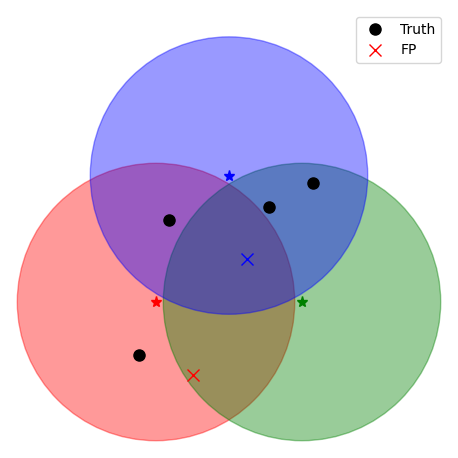

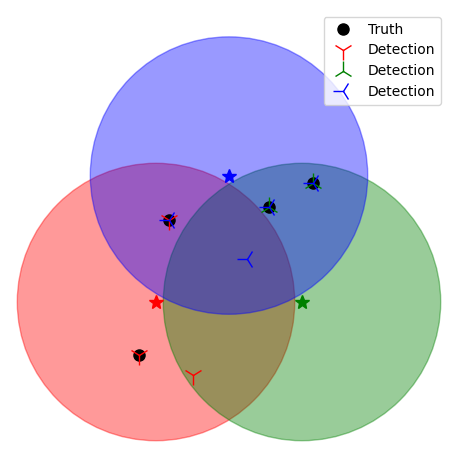

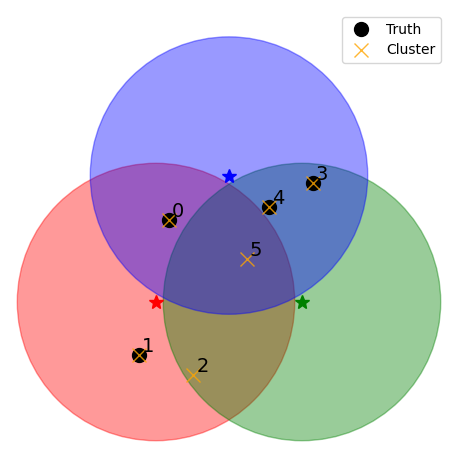

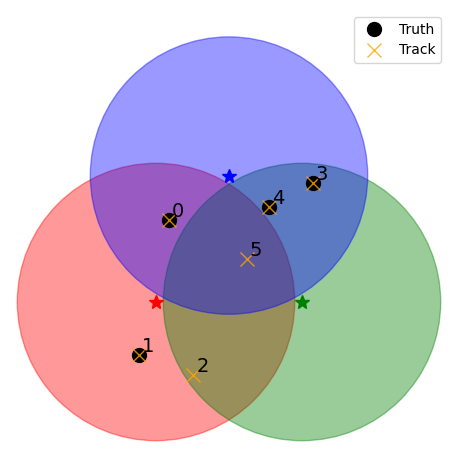

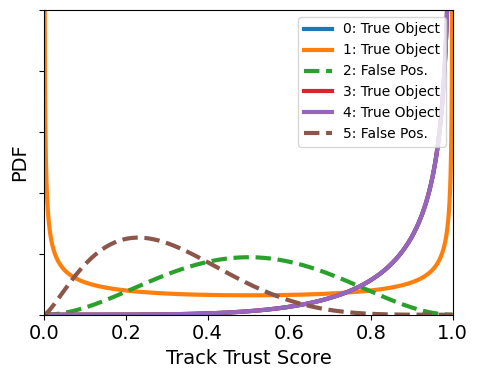

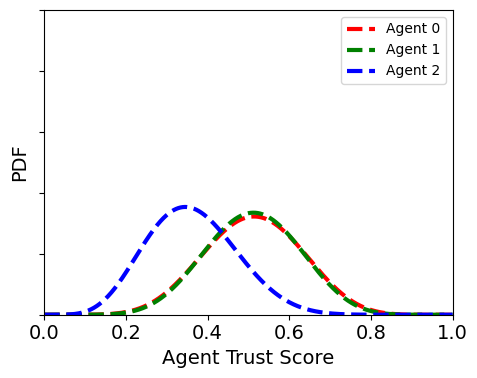

  0%|          | 0/1 [00:00<?, ?it/s]

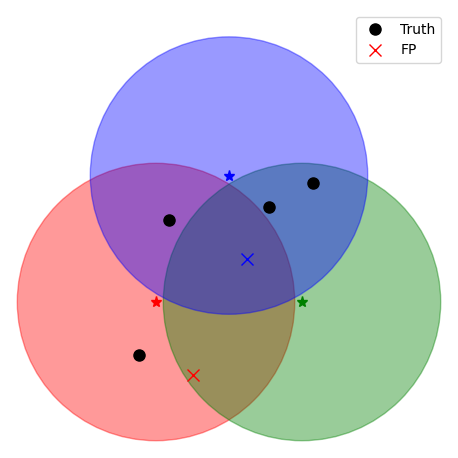

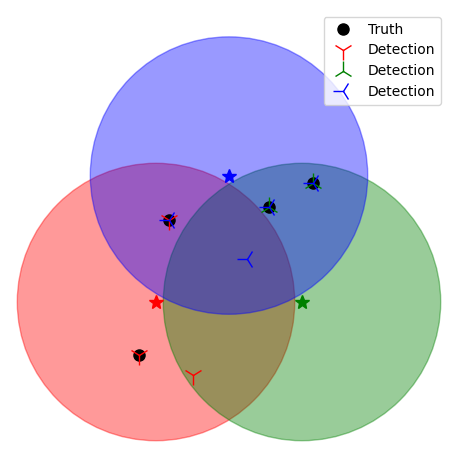

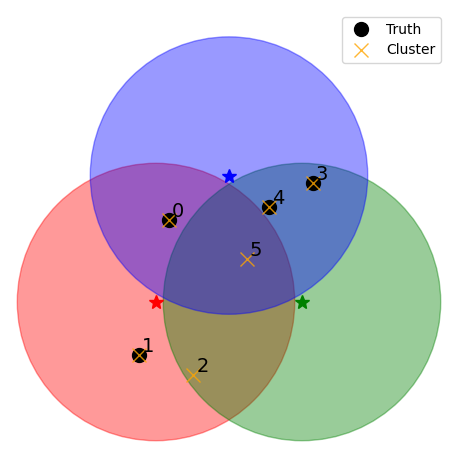

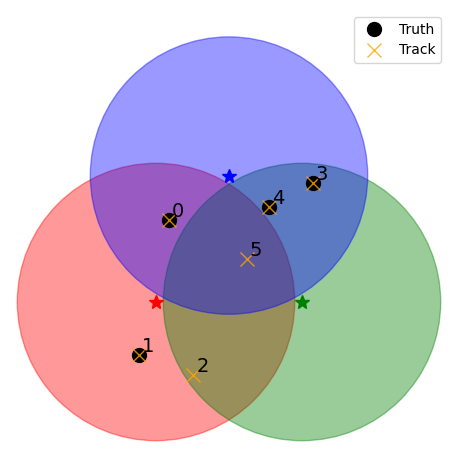

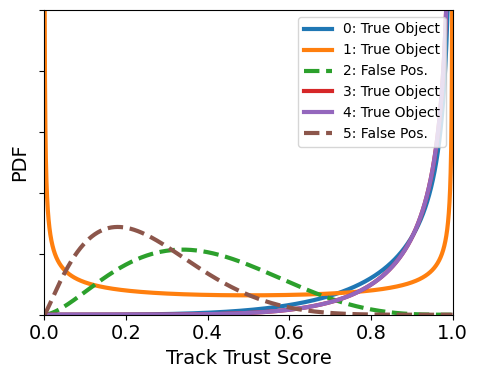

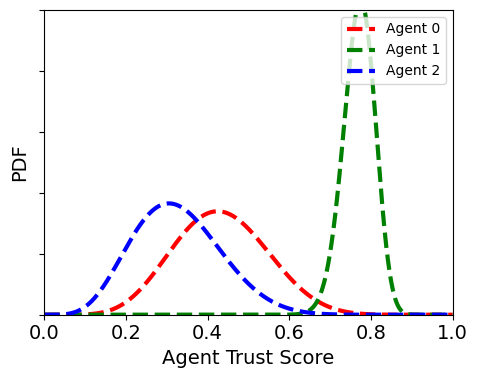

  0%|          | 0/1 [00:00<?, ?it/s]

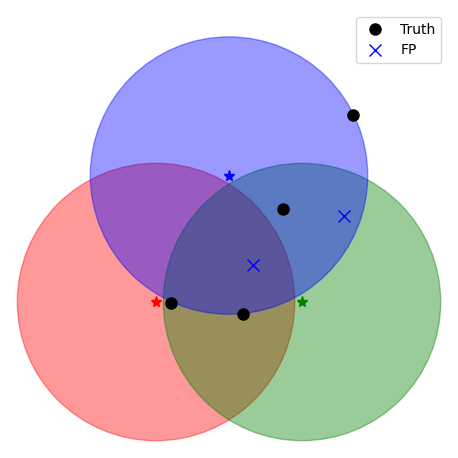

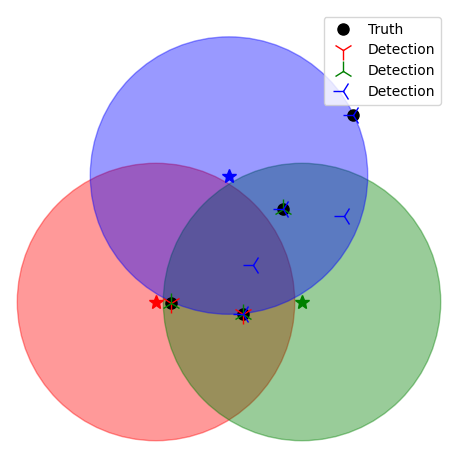

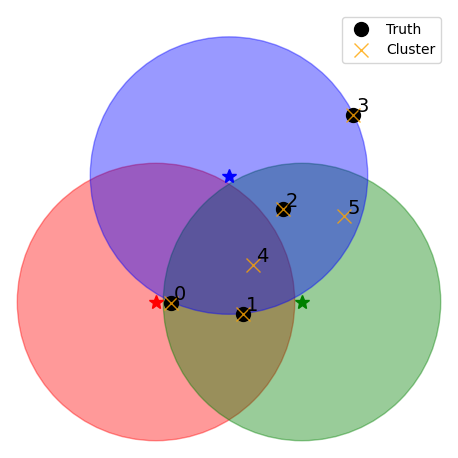

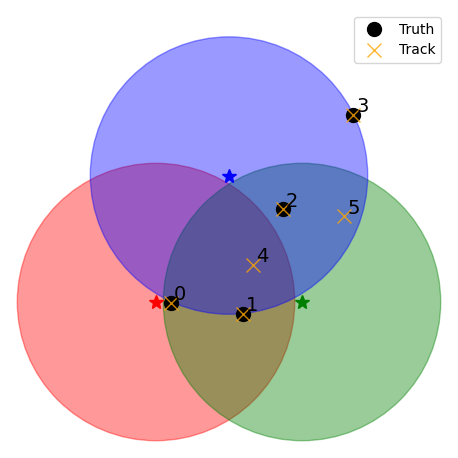

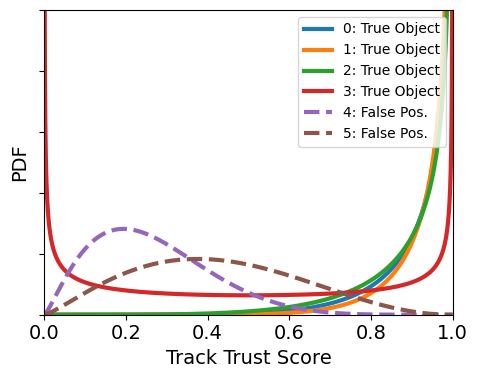

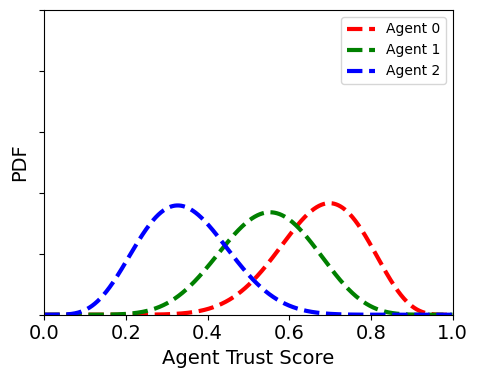

  0%|          | 0/1 [00:00<?, ?it/s]

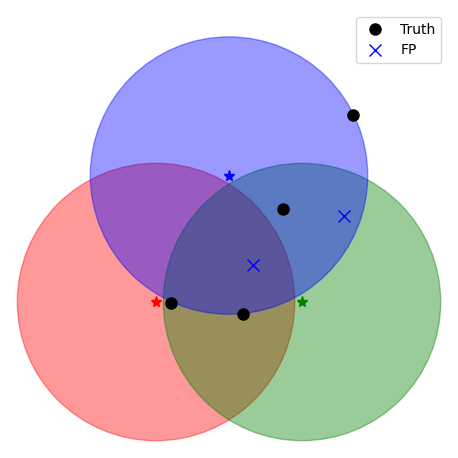

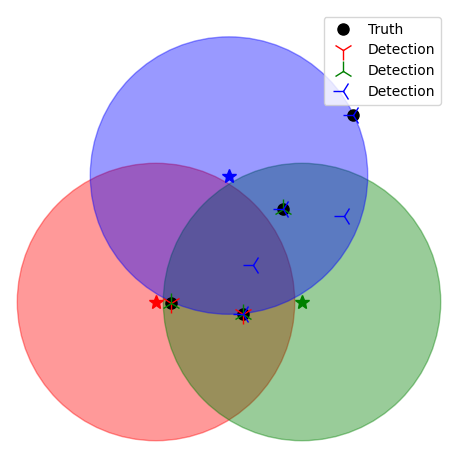

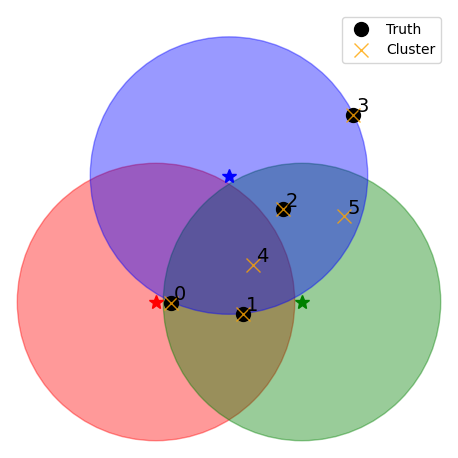

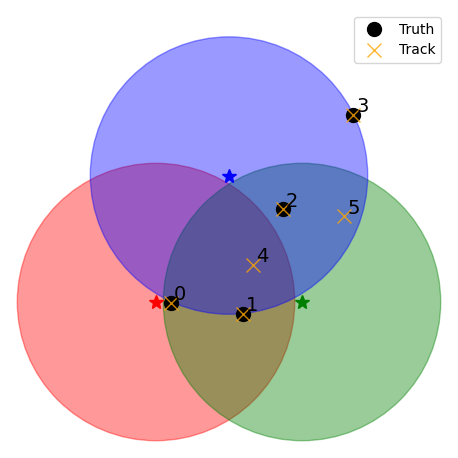

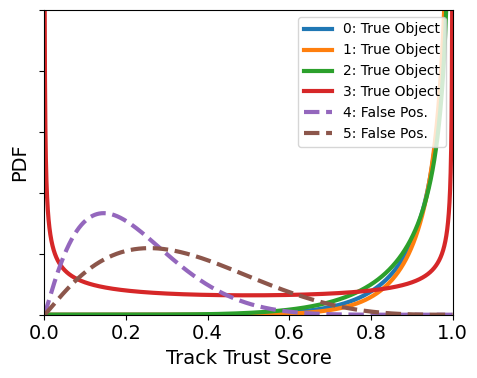

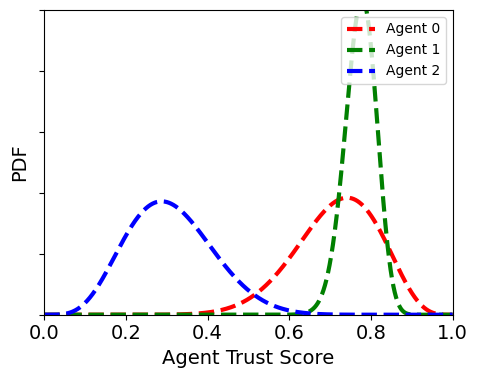

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [6]:
n_trials = 1

priors = [
    {},
    {1: {"type": "trusted", "strength": 100}}
]
fig_dirs = [
    "figures_case_{}_no_prior",
    "figures_case_{}_strong_prior"
]
seeds = [17, 49]
for i, seed in enumerate(seeds):
    for prior, fig_dir_ in zip(priors, fig_dirs):
        np.random.seed(seed)
        fig_dir = fig_dir_.format(i + 1)
        metrics_all = []
        for i_run in tqdm(range(n_trials)):
            trust_estimator, agents, fovs, objects, fps, fns, metrics = simulate_trust(
                radius=0.95,
                n_objects=4,
                n_fp=2,
                n_fn=0,
                frames=20,
                plot=True,
                force_case=False,
                prior_agents=prior,
                prior_tracks={},
                fig_dir=fig_dir,
            )
            for n_obs, met in metrics["cases_by_observer"].items():
                d = {"run": i_run, "n_observers": n_obs}
                d.update(met)
                metrics_all.append(d)
        df = pd.DataFrame(metrics_all)


In [7]:
# plot_metrics(df)

In [8]:
# plot_agents_objects(agents, fovs, objects, fps, fns)
# plot_trust(trust_estimator, objects=objects)